In [226]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib


In [1]:
%load_ext autoreload
%autoreload 2

import grequests
from src.dataloader import TSDataset, TSDataLoader
from src.utils import create_3d_array, standardize
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.RevIN import RevIN
from src.TSFM import TSFM
import torch
from matplotlib import pyplot as plt
from torchinfo import summary


/Users/abuj/opt/anaconda3/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from KEYS import LUMNIS_API_KEY

In [3]:
from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory

In [4]:
from lumnisfactors import LumnisFactors

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
temp_df_btc         = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-08")
temp_df_eth         = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-08")
temp_df_xmr         = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-08")

# btc_array = create_3d_array(temp_df_btc, temp_df_btc.index, 24)
# eth_array = create_3d_array(temp_df_eth, temp_df_eth.index, 24)
# xmr_array = create_3d_array(temp_df_xmr, temp_df_xmr.index, 24)


In [5]:

# standardize(temp_df_btc, 500, type='standard')['close'].plot()

cols = ['close', 'volume'] #temp_df_btc.columns

max_seq_len = 50


btc_array = create_3d_array(temp_df_btc[cols], temp_df_btc.index, max_seq_len)
eth_array = create_3d_array(temp_df_eth[cols], temp_df_eth.index, max_seq_len)
xmr_array = create_3d_array(temp_df_xmr[cols], temp_df_xmr.index, max_seq_len)

In [7]:
xmr_array.shape[-1]

2

In [ ]:
config = {
    'task': 'imputation',
    'model': 'transformer',
    'num_layers': 2,
    'd_model': 32,
    'num_heads': 4,
    'dim_feedforward': 128,
    'dropout': 0.1,
    'pos_encoding': 'learnable',
    'activation': 'relu',
    'normalization_layer': 'layer_norm',
    'freeze': False,
    'data_window_len': max_seq_len,
    'max_seq_len': max_seq_len,
}
ts_model = model_factory(config, xmr_array.shape[-1])

In [485]:
# Prepare your data as a dictionary
data_dict = {
    'dataset_btc': torch.from_numpy( btc_array).to(torch.float32),
    'dataset_eth': torch.from_numpy( eth_array).to(torch.float32),
    'dataset_xmr': torch.from_numpy( xmr_array).to(torch.float32)
}

# Create instances of TSDataset for each dataset
datasets = {name: TSDataset(data) for name, data in data_dict.items()}

# Create an instance of the custom data loader
ts_data_loader = TSDataLoader(datasets, batch_size=64)

num_epochs = 3


In [486]:
for epoch in range(num_epochs):
    for batch_data in ts_data_loader:
        for dataset_name, data in batch_data.items():

            if isinstance(data, tuple) and len(data) == 2:
                # Unpack data and labels
                inputs, labels = data
            else:
                inputs = data
            print(dataset_name, inputs.shape)
        break

dataset_btc torch.Size([64, 20, 2])
dataset_eth torch.Size([64, 20, 2])
dataset_xmr torch.Size([64, 20, 2])


In [493]:
# Init parameters
input_dims  = btc_array.shape[1:]
hidden_dims = 16 
output_dims = 16 

# Create an instance of the model
masked_ae = LSTMMaskedAutoencoderProjection(input_dims, hidden_dims, output_dims, use_revin=True)

# Print the model summary
summary(masked_ae, (128,) + input_dims)

# Train the model
masked_ae.warmup(dataset= datasets['dataset_btc'], n_epochs=10, batch_size=128, learning_rate=1e-3, log=True)

Layer (type:depth-idx)                   Output Shape              Param #
LSTMMaskedAutoencoderProjection          [128, 20, 2]              --
├─RevIN: 1-1                             [128, 20, 2]              4
├─LSTM: 1-2                              [128, 20, 16]             1,280
├─LSTM: 1-3                              [128, 20, 16]             2,176
├─Linear: 1-4                            [128, 20, 2]              34
├─RevIN: 1-5                             [128, 20, 2]              (recursive)
Total params: 3,494
Trainable params: 3,494
Non-trainable params: 0
Total mult-adds (M): 8.87
Input size (MB): 0.02
Forward/backward pass size (MB): 0.78
Params size (MB): 0.01
Estimated Total Size (MB): 0.81

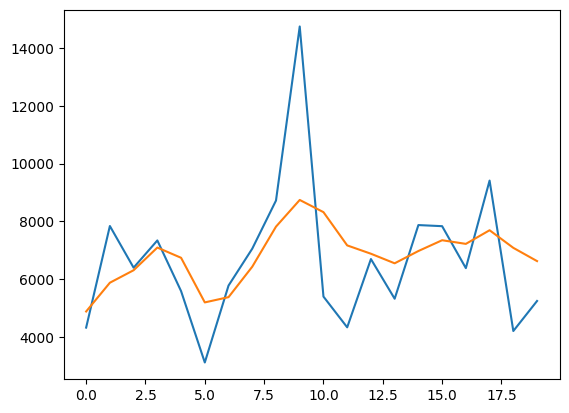

In [496]:
reconstructed_input = masked_ae(inputs, training=False)
plt.plot(inputs[0][:,1].detach().numpy()) 
plt.plot(reconstructed_input[0][:,1].detach().numpy()) 

plt.show()

embeddings = masked_ae.encode(inputs, type_of_pooling='mean')
# plt.plot( embeddings[:,2].detach().numpy() )

In [528]:
input_data_shapes_dict = {name: data.shape[1:] for name, data in data_dict.items()}
tsfm = TSFM(input_data_shapes_dict, batch_size=128, lr=1e-3, log=True, device='cpu')

In [529]:
loss = tsfm.fit(data_dict, n_epochs=10, log=True)

Warming up with 150 batches of size 128
Epoch: 0, Loss: 63929605.44833333
Epoch: 1, Loss: 25317634.34
Epoch: 2, Loss: 13692914.3925
Epoch: 3, Loss: 10837431.025833333
Epoch: 4, Loss: 13161785.487395834
Epoch: 5, Loss: 11059614.398125
Epoch: 6, Loss: 8042114.4025
Epoch: 7, Loss: 7014742.262291667
Epoch: 8, Loss: 5588967.471041666
Epoch: 9, Loss: 6743178.948125
Warming up with 149 batches of size 128
Epoch: 0, Loss: 403836680.97315437
Epoch: 1, Loss: 194326895.4899329
Epoch: 2, Loss: 130538597.8557047
Epoch: 3, Loss: 112793752.52348994
Epoch: 4, Loss: 136572576.58011746
Epoch: 5, Loss: 67979292.95889261
Epoch: 6, Loss: 90982014.17030202
Epoch: 7, Loss: 109210667.10738255
Epoch: 8, Loss: 52253810.38758389
Epoch: 9, Loss: 88377376.10486577
Warming up with 148 batches of size 128
Epoch: 0, Loss: 5597487.724662162
Epoch: 1, Loss: 4915042.993137669
Epoch: 2, Loss: 1975208.289326436
Epoch: 3, Loss: 2306994.304370777
Epoch: 4, Loss: 1586076.7847867399
Epoch: 5, Loss: 2219196.5794974663
Epoch: 6

{'dataset_btc': [], 'dataset_eth': [], 'dataset_xmr': []}